Import the required libraries.

In [19]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import tensorflow as tf
from keras.losses import binary_crossentropy,mean_squared_error

Import the dataset.

In [20]:
data=mnist.load_data()

Extract the training and test data from the dataset- 

In [21]:
train,test=data

In [22]:
train_x,train_y=train
test_x,test_y=test

In [23]:
test_y.shape

(10000,)

Clean the data-

  1. Scale the pixel intensities to range -1 to 1
  2. Flatten the images.
  3. Encode the labels. 

In [24]:
# Process the data

def clean_data(x,y):


  # Flatten the data
  samples=[]
  for sample in x[:]:
    samples.append(sample.flatten())

  x=np.array(samples)

  # Encode the labels
  enc=OneHotEncoder()

  enc.fit(y)

  onehotlabels = enc.transform(y).toarray()
  y=onehotlabels

  # Shuffle the data
  x,y=shuffle(x,y)

  # Scale the data
  scaler=MinMaxScaler(feature_range=(-1,1))

  x=scaler.fit_transform(x)

  print(x.shape,y.shape)



  return x,y



train_x,train_y=clean_data(train_x,train_y.reshape(-1,1))
test_x,test_y=clean_data(test_x,test_y.reshape(-1,1))

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


Define the latent dimensions. 

In [25]:
z_dim=100
num_classes=10

Define the noise and auxilary input which is the flattened central patch of images in our dataset. Also, build the generator which is fully connected DNN with the architecture- 110 x 200 x 400 x 784. The generator accepts the central patch as the auxilary input and the randomly generated noise from a normal distribution.

In [26]:
noise=Input(shape=(z_dim,))
aux_inp=Input(shape=(100,))

def build_generator():
  model=Sequential()
  
  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(units=784,activation='tanh',kernel_initializer='HeNormal'))

  model_inp=Concatenate(axis=1)([noise,aux_inp])

  gen_img=model(model_inp)

  return Model([noise,aux_inp],gen_img,name='generator')

generator = build_generator()
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 200)          0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 784)          437384      concatenate_2[0][0]      

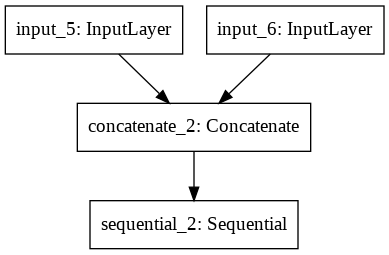

In [27]:
tf.keras.utils.plot_model(generator)

Build the discriminator which accepts the flattened images and classifies them into fake or real. It has the following architecture-

884 x 400 x 200 x 100 x 1.


In [28]:
def build_discriminator():
  model=Sequential()
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=100,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.1))

  model.add(Dense(units=1,activation='sigmoid',kernel_initializer='GlorotNormal'))

  dis_inp_img=Input(shape=(784,))
  dis_inp_label=Input(shape=(100,))

  model_inp=Concatenate(axis=1)([dis_inp_img,dis_inp_label])
  
  dis_pred=model(model_inp)

  return Model([dis_inp_img,dis_inp_label],dis_pred,name='Discriminator')

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 884)          0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            454401      concatenate_3[0][0]  

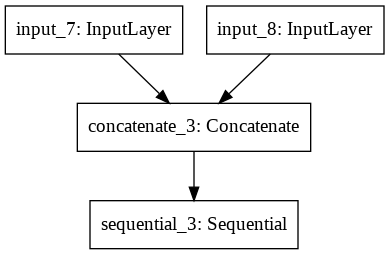

In [29]:
tf.keras.utils.plot_model(discriminator)

In [30]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['binary_accuracy'])

Let's build the CGAN model. The model uses the generator to generate fake images and the discriminator is validate the generated images.

In [31]:
discriminator.trainable = False
img = generator([noise,aux_inp])
prediction = discriminator([img, aux_inp])

img=tf.reshape(img, shape=(-1,28,28))
img=img[:,9:19,9:19]
img=tf.reshape(img, shape=(-1,100))

conditionalGAN_model = Model([noise, aux_inp], [prediction,img])

In [32]:
GANOptimizer=Adam(0.0002,0.5)

In [33]:
conditionalGAN_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 784)          437384      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape_2 (TensorFl [(None, 28, 28)]     0           generator[0][0]       

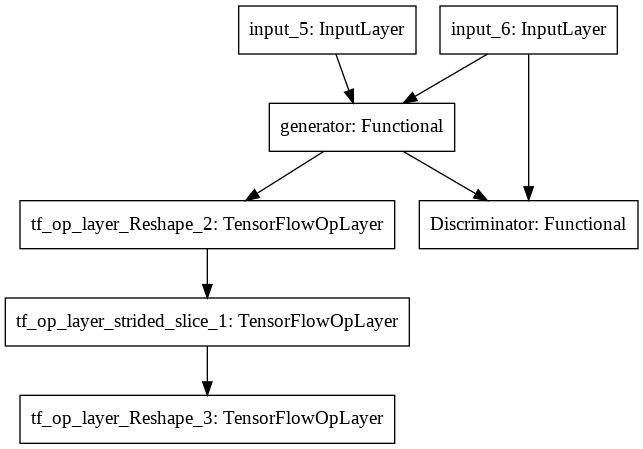

In [34]:
tf.keras.utils.plot_model(conditionalGAN_model)

In [35]:
conditionalGAN_model.compile(loss= ['binary_crossentropy','mse'],loss_weights = [1,0.1], optimizer = Adam(0.0002,0.5))

Lets train the GAN and discrimator model for 200 epochs.

In [ ]:
import os

from tensorflow.keras import backend as K

if 'images' not in os.listdir():
    os.mkdir('images')


test_label_dict={}
for indx,label in enumerate(np.argmax(test_y,axis=1)):
  if label in test_label_dict:
    test_label_dict[label].append(indx)
  else:
    test_label_dict[label]=[indx]

def save_image(epoch):
  
  r, c = 2,5
  z = np.random.normal(0,1,(r*c, z_dim))
  label_indexes = [(label,np.random.choice(indexes)) for label,indexes in test_label_dict.items()]
  label_indexes.sort(key=lambda x: x[0])
  labels=[test_x[index] for _,index in label_indexes]
  labels=np.array(labels)
  labels=labels.reshape((len(labels),28,28))
  labels=labels[:,9:19,9:19]
  labels=labels.reshape((len(labels),100))


  gen_image = generator.predict([z,labels])
  gen_image = 0.5 * gen_image + 0.5
    
  fig, axes = plt.subplots(r,c, figsize = (10,10))
  count = 0
  for i in range(r):
    for j in range(c):
      axes[i,j].imshow(gen_image[count,:].reshape((28,28)),cmap = 'gray')
      axes[i,j].axis('off')
      axes[i,j].set_title(f"Digit: {count}")
      count+=1
  plt.savefig(f'images/cgan_{epoch}.jpg')
  plt.close()


def train(epochs, batch_size, save_interval):
  real = np.ones(shape= (batch_size, 1))
  fake = np.zeros(shape = (batch_size,1))
  
  real_accs=[]
  fake_accs=[]

  gen_losses=[]
  d_losses=[]
  for epoch in range(epochs):
    
    for i in range(0,len(train_x),batch_size):
      
      discriminator.trainable = True
      
      img = train_x[i:i+batch_size,:]
      labels=img.reshape((len(img),28,28))
      labels=labels[:,9:19,9:19]
      labels=labels.reshape((len(labels),100))

      d_batch_loss_real,d_batch_acc_real = discriminator.train_on_batch([img, labels], real[:len(labels),:])

      
      z = np.random.normal(0,1,size = (len(labels), z_dim))
      gen_img = generator.predict([z,labels])

      d_batch_loss_fake,d_batch_acc_fake = discriminator.train_on_batch([gen_img, labels], fake[:len(labels),:])
      d_loss=(d_batch_loss_real+d_batch_loss_fake)/2



      discriminator.trainable = False
      z = np.random.normal(0,1,size = (len(labels), z_dim))
      g_loss = conditionalGAN_model.train_on_batch([z,labels],[real[:len(labels)],labels])


    epoch_real_accuracy=d_batch_acc_real
    epoch_fake_accuracy=d_batch_acc_fake
    epoch_gen_loss=float(K.sum(g_loss,axis=0))
    epoch_d_losses=d_loss
    print(f"Epoch: {epoch} Disc. Loss: {epoch_d_losses} Real Img Accuracy: {epoch_real_accuracy} Fake Img Accuracy: {epoch_fake_accuracy} Gen Loss- {epoch_gen_loss}")

    real_accs.append(epoch_real_accuracy)
    fake_accs.append(epoch_fake_accuracy)
    gen_losses.append(epoch_gen_loss)
    d_losses.append(epoch_d_losses)

    if epoch % save_interval == 0:
      save_image(epoch)

  return (real_accs,fake_accs,gen_losses,d_losses)



history=train(200, 64, 10)

Let's generate ten images of each digit by giving only the centre patch of the test images as input and the random noise generated normally-

(100, 100)


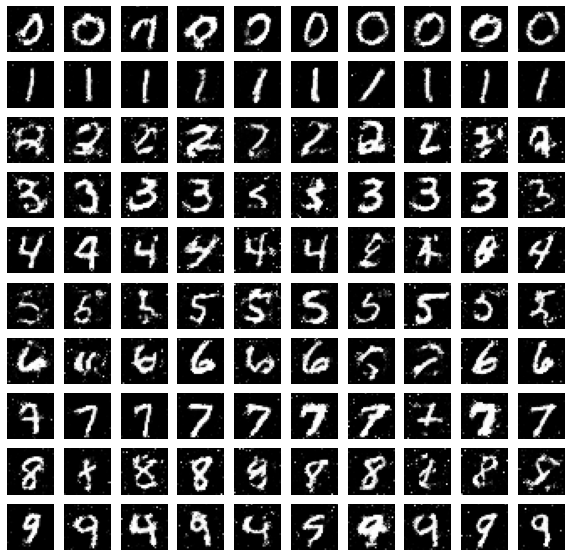

In [41]:
r, c = 10,10
z = np.random.normal(0,1,(r*c, z_dim))
label_indexes = [(label,np.random.choice(indexes,size=(10,))) for label,indexes in test_label_dict.items()]
label_indexes.sort(key=lambda x: x[0])

labels=[]
for _,indices in label_indexes:
  for index in indices:
    labels.append(test_x[index])
labels=np.array(labels)
labels=labels.reshape((len(labels),28,28))
labels=labels[:,9:19,9:19]
labels=labels.reshape((len(labels),100))
print(labels.shape)

gen_image = generator.predict([z,labels])
gen_image = 0.5 * gen_image + 0.5
    
fig, axes = plt.subplots(r,c, figsize = (10,10))
count = 0
for i in range(r):
  for j in range(c):
    axes[i,j].imshow(gen_image[count,:].reshape((28,28)),cmap = 'gray')
    axes[i,j].axis('off')
    #axes[i,j].set_title(f"Digit: {count}")
    count+=1

The results seem decent. Let's see the ground truth images- 

In [44]:
ground_truth_images=[]

for _,indices in label_indexes:
  for index in indices:
    ground_truth_images.append(test_x[index])

ground_truth_images=np.array(ground_truth_images)
ground_truth_images.shape

(100, 784)

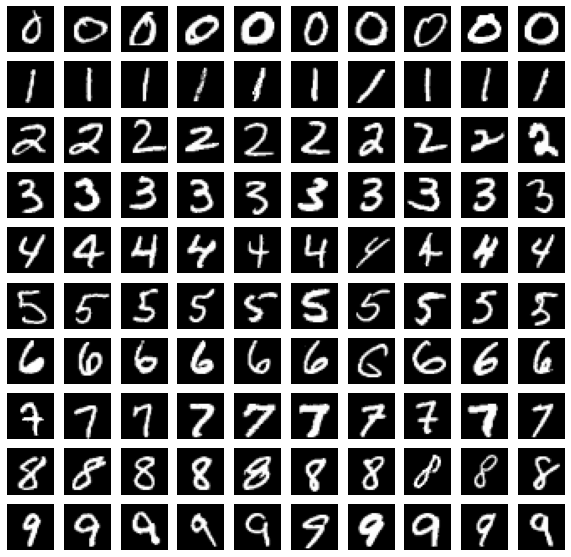

In [45]:
fig, axes = plt.subplots(r,c, figsize = (10,10))
count = 0
for i in range(r):
  for j in range(c):
    axes[i,j].imshow(ground_truth_images[count,:].reshape((28,28)),cmap = 'gray')
    axes[i,j].axis('off')
    #axes[i,j].set_title(f"Digit: {count}")
    count+=1

Above we can see that the generated images are pretty close to the ground truth.